In [1]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from noise_utils import AddNoise, RemoveReadoutErrors

plt.style.use({'figure.facecolor':'white'})
D = {'output': 'mpl', 'fold': -1}

In [2]:
backend_1 = FakeLima()
properties_1 = get_backend_properties_v1(backend_1)
backend_2 = FakeBelem()
properties_2 = get_backend_properties_v1(backend_2)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_1 = AerSimulator.from_backend(backend_1) # Noisy
backend_noisy_2 = AerSimulator.from_backend(backend_2) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_1 = {'shots': 10000, 'backend': backend_noisy_1, 'name': 'noisy'}
run_config_noisy_2 = {'shots': 10000, 'backend': backend_noisy_2, 'name': 'noisy'}

In [3]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [15]:
# model_path_1 = './model/ising_init_from_qasm/gnn1.pth'
# model_path_2 = './model/ising_init_from_qasm/mlp1_smaller.pth'
# model_path_3 = './model/ising_init_from_qasm/ols_full.pk'
# model_path_4 = './model/ising_init_from_qasm/ols.pk'
# model_path_5 = './model/ising_init_from_qasm/rfr_list.pk'

# model_path_1 = './model/ising_init_from_qasm_coherent/gnn1.pth'
# model_path_2 = './model/ising_init_from_qasm_coherent/mlp1_smaller.pth'
# model_path_3 = './model/ising_init_from_qasm_coherent/ols_full.pk'
# model_path_4 = './model/ising_init_from_qasm_coherent/ols.pk'
# model_path_5 = './model/ising_init_from_qasm_coherent/rfr_list.pk'

# model_path_1 = './model/ising_init_from_qasm_no_readout/gnn1.pth'
# model_path_2 = './model/ising_init_from_qasm_no_readout/mlp1_smaller_2.pth'
# model_path_3 = './model/ising_init_from_qasm_no_readout/ols_full.pk'
# model_path_5 = './model/ising_init_from_qasm_no_readout/rfr_list.pk'

# model_path_1 = './model/random_circuits/gnn1.pth'
model_path_2 = './model/random_circuits/mlp1.pth'
# model_path_3 = './model/random_circuits/ols_full.pk'
# model_path_4 = './model/random_circuits/ols.pk'
model_path_5 = './model/random_circuits/rfr_list.pk'

In [16]:
models = []

# model_1 = ExpValCircuitGraphModel(
#     num_node_features=22,
#     hidden_channels=15
# )
# model_1.load_state_dict(torch.load(model_path_1), strict=True)
# model_1.eval()
# models.append((model_1, 'gnn'))
#
model_2 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_2.load_state_dict(torch.load(model_path_2), strict=True)
model_2.eval()
models.append((model_2, 'mlp'))
#
# with open(model_path_3, 'rb') as f:
#     model_3 = pickle.load(f)
# models.append((model_3, 'ols_full'))

# with open(model_path_4, 'rb') as f:
#     model_4 = pickle.load(f)
# models.append((model_4, 'ols'))

with open(model_path_5, 'rb') as f:
    model_5 = pickle.load(f)
models.append((model_5, 'rfr_list'))

models.append((None, 'zne'))

In [17]:
import re
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    steps = []
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            step = int(re.search(r'\d+', data_file.split('/')[-1]).group())
            for entry in pickle.load(open(data_file, 'rb')):
                steps.append(step)
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals, steps

# test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/ising_init_from_qasm_no_readout/val_extra/', '.pk')
# test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/ising_init_from_qasm/val_Zonly/', '.pk')
# print(len(test_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, steps = load_circuits('./data/haoran_mbd/random_circuits/val/', '.pk')
print(len(test_circuits))

test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]

  0%|          | 0/10 [00:00<?, ?it/s]

2000


In [18]:
with open('./zne_mitigated/random_circuits.pk', 'rb') as file:
    zne_mitigated = pickle.load(file)
print(len(zne_mitigated))

2000


In [39]:
to_df = []

start = 0 #300*9
end = 100000000 #300*10

for i, (circ, ideal_exp_val, noisy_exp_val, zne_val, step) in tqdm(enumerate(zip(test_circuits[start:end], test_ideal_exp_vals[start:end], test_noisy_exp_vals[start:end], zne_mitigated[start:end], steps[start:end])), total=len(test_circuits[start:end])):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val
    row['step'] = step

    circ_trans = circ

################################### Same as trained ##################################
    X1, _ = encode_data([circ_trans], properties_1, ideal_exp_val, [noisy_exp_val], num_qubits=4)
    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name+'_1'] = model(X1).tolist()[0]
        elif name == 'gnn':
            row[name+'_1'] = model(entry1.noisy_0, entry1.observable, entry1.circuit_depth, entry1.x, entry1.edge_index, entry1.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name+'_1'] = model.predict(X1).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name+'_1'] = model.predict(X1[:, -4:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name+'_1'] = []
            for q, m in enumerate(model):
                row[name+'_1'].append(m.predict(X1))
            row[name+'_1'] = np.array(row[name+'_1']).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_val
        else:
            raise NotImplementedError

################################### Different Noise Model ##################################
    X2, _ = encode_data([circ_trans], properties_2, ideal_exp_val, [noisy_exp_val], num_qubits=4)
    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name+'_2'] = model(X2).tolist()[0]
        elif name == 'gnn':
            row[name+'_2'] = model(entry2.noisy_0, entry2.observable, entry2.circuit_depth, entry2.x, entry2.edge_index, entry2.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name+'_2'] = model.predict(X2).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name+'_2'] = model.predict(X2[:, -4:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name+'_2'] = []
            for q, m in enumerate(model):
                row[name+'_2'].append(m.predict(X2))
            row[name+'_2'] = np.array(row[name+'_2']).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_val
        else:
            raise NotImplementedError

################################### Remove noisy expectation values ##################################
    X3, _ = encode_data([circ_trans], properties_1, ideal_exp_val, [[0, 0, 0, 0]], num_qubits=4)
    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name+'_3'] = model(X3).tolist()[0]
        elif name == 'gnn':
            row[name+'_3'] = model(entry3.noisy_0, entry3.observable, entry3.circuit_depth, entry3.x, entry3.edge_index, entry3.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name+'_3'] = model.predict(X3).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name+'_3'] = model.predict(X3[:, -4:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name+'_3'] = []
            for q, m in enumerate(model):
                row[name+'_3'].append(m.predict(X3))
            row[name+'_3'] = np.array(row[name+'_3']).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_val
        else:
            raise NotImplementedError

    to_df.append(row)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [26]:
# def fix_zne_bug(df):
#     for index, row in df.iterrows():
#         if (row['step'] == 0) and (row['ideal'][2] == -1) and (row['zne'][2] == 0):
#             row['zne'][2] = -1
#             df.at[index, 'zne'] = row['zne']
#     return df

In [40]:
df = pd.DataFrame(to_df)
# df = fix_zne_bug(df)

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_13383/2111502039.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_13383/2111502039.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))


In [41]:
df_mean

,L2_noisy,L2_mlp_1,L2_rfr_list_1,L2_zne,L2_mlp_2,L2_rfr_list_2,L2_mlp_3,L2_rfr_list_3
step,,,,,,,,
0,0.098900,0.049650,0.040694,0.100689,0.135760,0.040694,1.378474,1.367431
2,0.114354,0.049631,0.033992,0.101875,0.144037,0.033992,1.683318,1.650084
4,0.143628,0.064947,0.049836,0.114996,0.146513,0.049836,1.522912,1.502074
6,0.165877,0.076103,0.068327,0.124068,0.153645,0.068327,1.333812,1.320390
8,0.180392,0.085492,0.074809,0.123375,0.162850,0.074809,1.321798,1.305824
10,0.185898,0.092612,0.089736,0.129256,0.165462,0.089736,0.995794,0.990210
12,0.180267,0.096015,0.094753,0.118769,0.164731,0.094753,0.939336,0.926908
14,0.200598,0.105302,0.104333,0.123706,0.179218,0.104333,0.946761,0.938162
16,0.193837,0.102518,0.100765,0.120620,0.177874,0.100765,0.862619,0.851652


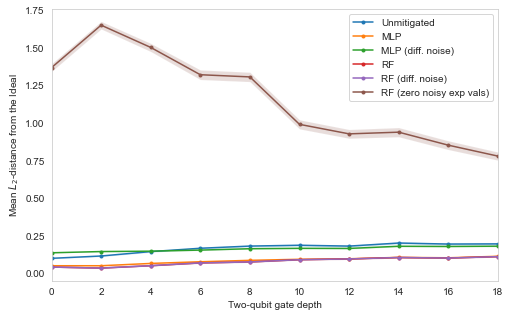

In [56]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
# legend_labels = ['Unmitigated', 'MLP', 'MLP (diff. noise)', 'RF', 'RF (diff. noise']
# for i, col in enumerate(['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']):
legend_labels = ['Unmitigated', 'MLP', 'MLP (diff. noise)', 'RF', 'RF (diff. noise)', 'RF (zero noisy exp vals)']
for i, col in enumerate(['L2_noisy', 'L2_mlp_1', 'L2_mlp_2', 'L2_rfr_list_1', 'L2_rfr_list_2', 'L2_rfr_list_3']):
    plt.plot(xs, df_mean[col], label=legend_labels[i], marker='.')
    plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Two-qubit gate depth')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
# plt.ylim([0, 0.53])
plt.xlim([0, 18])
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax)
plt.legend()
plt.grid(None)
plt.show()

In [53]:
# to_dump = {
#     'df': df,
#     'df_mean': df_mean,
#     'df_ste': df_ste,
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/no_readout_over_depths.pk', 'wb') as file:
#     pickle.dump(to_dump, file)

In [ ]:
# df_hue = []
# for i in range(len(df)):
#     for col in ['RMSE_noisy', 'RMSE_rfr_list', 'RMSE_zne']:
#         df_hue.append([df.loc[i, 'step'], df.loc[i, col], col])
# df_hue = pd.DataFrame(df_hue)
# df_hue.columns = ['step', 'RMSE', 'name']
#
# plt.figure(figsize=(15, 5))
# plt.style.use({'figure.facecolor':'white'})
# g = sns.boxplot(data=df_hue, x='step', y='RMSE', hue='name')
# g.legend(title="")
# new_legend_labels = ['Unmitigated', 'Mitigated by RF', 'Mitigated by ZNE']
# for i in range(3):
#     g.legend_.texts[i].set_text(new_legend_labels[i])
# plt.xlabel('Trotter Steps')
# plt.ylabel('RMSE from Ideal Expectation Values')
# plt.show()

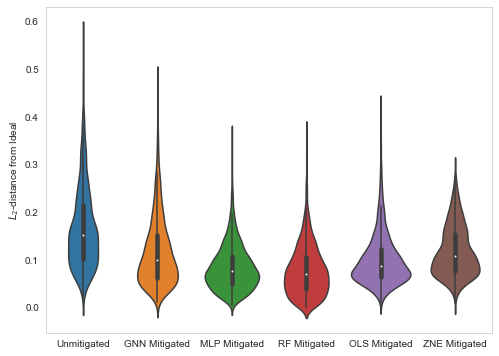

In [21]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df[['L2_noisy', 'L2_gnn', 'L2_mlp', 'L2_rfr_list', 'L2_ols_full', 'L2_zne']])
# labels = ax.get_xticklabels()
ax.set_xticklabels(['Unmitigated', 'GNN Mitigated', 'MLP Mitigated', 'RF Mitigated', 'OLS Mitigated', 'ZNE Mitigated'])
plt.ylabel(r'$L_2$-distance from Ideal')
# plt.ylim([-0.003, 0.02])
ax.grid(False)
plt.show()

In [23]:
# to_dump = {
#     'df': df,
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/random_circuits.pk', 'wb') as file:
#     pickle.dump(to_dump, file)